In [ ]:
%load_ext autoreload
%autoreload 2

# 2D Viewfactor Modelling tool
This notebook aims to create a unified 2D modelling tool for pvarrays. It can use as backend Sunpower's [pvfactors](https://github.com/SunPower/pvfactors) or NREL's [bifacialVF](https://github.com/NREL/bifacialvf). 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import *

Setup some paths using pathlib

In [3]:
CWD = Path.cwd().parent
PATH = CWD/'data'
PATH.ls()

[PosixPath('/home/tc256760/Documents/bifacial_model_validation/data/ines_data.hdf')]

In [4]:
data = pd.read_hdf(PATH/'ines_data.hdf'); data.head()
day = '18 Jul 2017'
data_small = data[day]

## We provide input data every 5 minutes for a coerced year 2017.

This is a multiindex DataFrame, that has keys: 
- `meteo`: all input meteorological data, ghi from pyrano, DNI from pyrhelio.
- `reference_cells`: ref_A is a front facing reference cell, the others are rear facing
- `sunpos`: the sunposition computed using PVLIB
- `tracker`: SAT computed using PVLIB, no backtrack

So one can do `data.meteo` to see the nested DataFrame 

In [5]:
data.meteo.head()

,temp_air,ghi,dni,dhi,pressure,humidity
date,,,,,,
2017-01-01 07:25:00,-2.18,0.0,0.0,0.0,998.25,95.9
2017-01-01 07:30:00,-2.21,0.0,0.0,0.0,998.28,95.8
2017-01-01 07:35:00,-2.20,0.0,0.0,0.0,998.22,96.0
2017-01-01 07:40:00,-2.20,0.0,0.0,0.0,998.22,96.3
2017-01-01 07:45:00,-2.18,0.0,0.0,0.0,998.25,96.2


These are the reference cells from the array. 
- `ref_A` is facing front in the top of the array
- `ref_A2` is facing back in between both modules, in the left of the array
- `ref_B2` is facing back in between both modules, in the center of the array, 2D models should compare against this cell.
- `ref_E2` is facing back in between both modules, in the rigthmost of the array

In [6]:
data.reference_cells.head()

,ref_A,ref_A2,ref_B2,ref_E2
date,,,,
2017-01-01 07:25:00,0.0,0.0,0.0,0.0
2017-01-01 07:30:00,0.0,0.0,0.0,0.0
2017-01-01 07:35:00,0.0,0.0,0.0,0.0
2017-01-01 07:40:00,0.0,0.0,0.0,0.0
2017-01-01 07:45:00,0.0,0.0,0.0,0.0


## Define the PV plant
We define the PV plant geometry

In [7]:
from vf2d import system_def, merge_data

In [8]:
gps_data = {'Name':'Chambery', 'Latitude': 45.637001, 'Longitude': 5.881, 'Elevation': 235.0, 'TZ':+2}

In [9]:
pvarray_parameters = system_def(n_pvrows=2,
                                n_modules_vertically=2, #number of modules stacked together in each structure. Int.
                                module_size = (1.01, 1.69), #(width, height) this is a portrait module.
                                h_ground = 0.77, #height from the ground for the lower module, in meters.
                                surface_tilt = 30, #tilt of the installation, in degrees.
                                surface_azimuth = 180, #orientation of the axis, degrees from N, clockwise.
                                axis_azimuth = 90, #Direction facing the modules, degrees from N, clockwise.
                                albedo = 0.4, #Albedo from ground, can be constant or a value per timestep. Between 0 and 1.
                                rtr_spacing = 9.4, #row2row distance, in meters.
                                frontSurface = "glass", #glass or ARglass
                                backSurface = "glass",
                                back_measure_points = 10,
                                row_type='first', #where to recover the data, 'first', 'interior' or 'last'
                                gps_data=gps_data, # a dict containing 'Name', 'Latitute', 'Longitude', 'Elevation', 'TZ'
                               )

In [10]:
pvarray_parameters

{'pvfactors': {'n_pvrows': 2,
  'pvrow_height': 1.6149999999999998,
  'pvrow_width': 3.38,
  'tracking': False,
  'axis_azimuth': 90,
  'surface_tilt': 30,
  'surface_azimuth': 180,
  'albedo': 0.4,
  'gcr': 0.35957446808510635,
  'rho_front_pvrow': 0.04336154977936508,
  'rho_back_pvrow': 0.04336154977936508,
  'cut': {0: {'front': 1, 'back': 10}, 1: {'front': 1, 'back': 1}}},
 'bifacialvf': {'beta': 30,
  'sazm': 180,
  'C': 0.227810650887574,
  'rtr': 2.7810650887573964,
  'rowType': 'first',
  'transFactor': 0.013,
  'cellRows': 10,
  'PVfrontSurface': 'glass',
  'PVbackSurface': 'glass',
  'albedo': 0.4,
  'tracking': False},
 'gps_data': {'Name': 'Chambery',
  'Latitude': 45.637001,
  'Longitude': 5.881,
  'Elevation': 235.0,
  'TZ': 2}}

## Merge Data
We create a unified DataFrame with the data needed for the simulation

In [11]:
merged_data = merge_data(data_small.meteo, 
                         data_small.sunpos, 
                         pvarray_parameters['pvfactors']['surface_tilt'], 
                         pvarray_parameters['pvfactors']['surface_azimuth'],
                         pvarray_parameters['pvfactors']['albedo'])

In [12]:
merged_data.head()

,ghi,dni,dhi,zenith,azimuth,elevation,surface_tilt,surface_azimuth,albedo
date,,,,,,,,,
2017-07-18 04:10:00,0.00,0.0,0.00,91.000000,59.572309,0.328591,30,180,0.4
2017-07-18 04:15:00,0.00,0.0,0.00,91.000000,60.460925,1.085116,30,180,0.4
2017-07-18 04:20:00,10.73,0.0,10.73,88.151694,61.344053,1.848306,30,180,0.4
2017-07-18 04:25:00,13.31,0.0,13.32,87.382059,62.221953,2.617941,30,180,0.4
2017-07-18 04:30:00,16.51,0.0,16.51,86.606199,63.094892,3.393801,30,180,0.4


## PVfactors

In [13]:
from mypvfactors import *

This is just a wrapper around the `run_parallel_engine` and the `run_full_mode` functions from pvfactors. Don't know why with pvfactors 1.2 the parallel mode is so slow.

In [14]:
pvfactors_out = pvfactors_engine_run(merged_data, pvarray_parameters['pvfactors'], parallel=4)

100%|██████████| 45/45 [00:02<00:00, 21.54it/s]
INFO:pvfactors.run:Parallel calculation elapsed time: 2.1532654762268066 sec


In [15]:
pvfactors_out.head()

,qinc_front,qinc_back_mean,qinc_back_0,qinc_back_1,qinc_back_2,qinc_back_3,qinc_back_4,qinc_back_5,qinc_back_6,qinc_back_7,qinc_back_8,qinc_back_9
date,,,,,,,,,,,,
2017-07-18 04:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-18 04:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-18 04:20:00,9.833055,4.623675,4.637035,4.633997,4.630985,4.628000,4.625040,4.622106,4.619198,4.616315,4.613456,4.610622
2017-07-18 04:25:00,12.209506,5.739735,5.756319,5.752547,5.748809,5.745103,5.741429,5.737787,5.734176,5.730597,5.727049,5.723531
2017-07-18 04:30:00,15.135242,7.131558,7.152102,7.147430,7.142799,7.138208,7.133657,7.129146,7.124673,7.120239,7.115844,7.111486


## BifacialVF

In [16]:
from mybifacialvf import *

The `bifacialvf_engine_run` method is just a wrapper around the '`simulate` method. It has a nice formater that will transform the output DataFrame in the same format as the one produced by pvfactors to be diectly comparable.

In [17]:
bifacialvf_out = bifacialvf_engine_run(merged_data,  pvarray_parameters['bifacialvf'], gps_data)

  0%|          | 0/181 [00:00<?, ?it/s]/home/tc256760/anaconda3/envs/bifacial_model_validation/lib/python3.7/site-packages/bifacialvf/vf.py:640: RuntimeWarning: divide by zero encountered in double_scalars
  projectedX1 = PcellX - np.float64(PcellY) / math.tan(startElvDown);      # Projection of ElvDown to ground in -x direction
  8%|▊         | 14/181 [00:00<00:01, 135.92it/s]

 
********* 
Running Simulation for TMY3:  Chambery
Location:   Chambery
Lat:  45.637001  Long:  5.881  Tz  2
Parameters: beta:  30   Sazm:  180   Height:  0.227810650887574   rtr separation:  2.7810650887573964   Row type:  first   Albedo:  0.4
Saving into output.csv
 
 


100%|██████████| 181/181 [00:01<00:00, 124.24it/s]

Finished


In [18]:
bifacialvf_out.head()

,qinc_front,qinc_back_mean,qinc_back_0,qinc_back_1,qinc_back_2,qinc_back_3,qinc_back_4,qinc_back_5,qinc_back_6,qinc_back_7,qinc_back_8,qinc_back_9
date,,,,,,,,,,,,
2017-07-18 04:20:00,9.815920,2.268114,2.749797,2.659666,2.522485,2.379542,2.237317,2.106785,1.995712,1.960718,1.969415,2.099705
2017-07-18 04:25:00,11.641471,2.674164,3.054947,2.943875,2.851112,2.748019,2.642287,2.548221,2.474729,2.431608,2.442500,2.604337
2017-07-18 04:30:00,14.435639,3.316199,3.790636,3.652954,3.537097,3.408473,3.276616,3.159253,3.067431,3.013979,3.027479,3.228073
2017-07-18 04:35:00,17.239073,3.960379,4.528964,4.364589,4.225493,4.071188,3.913060,3.772263,3.661994,3.598178,3.614294,3.853767
2017-07-18 04:40:00,19.759487,4.553476,5.205977,5.017644,4.857908,4.680755,4.499212,4.337567,4.210903,4.137786,4.156275,4.430734


## Refactor
We can refactor the whole pipeline in one single run_simulation function that we will extend to use bifacialvf

In [19]:
def run_simulation(data, pvarray_parameters, engine='pvfactors', **kwargs):
    merged_data = merge_data(data.meteo, 
                             data.sunpos,                          
                             pvarray_parameters['pvfactors']['surface_tilt'], 
                             pvarray_parameters['pvfactors']['surface_azimuth'],
                             pvarray_parameters['pvfactors']['albedo'])
    if engine == 'pvfactors':   
        res = pvfactors_engine_run(merged_data, pvarray_parameters['pvfactors'],**kwargs)
    if engine == 'bifacialvf':
        res = bifacialvf_engine_run(merged_data, pvarray_parameters['bifacialvf'], gps_data=pvarray_parameters['gps_data'],**kwargs)
    return res

In [20]:
pvfactors_out = run_simulation(data_small, pvarray_parameters, engine='pvfactors', parallel=4)

100%|██████████| 45/45 [00:02<00:00, 20.40it/s]
INFO:pvfactors.run:Parallel calculation elapsed time: 2.2797365188598633 sec


In [21]:
bifacialvf_out = run_simulation(data_small, pvarray_parameters, engine='bifacialvf')

  8%|▊         | 14/181 [00:00<00:01, 131.22it/s]

 
********* 
Running Simulation for TMY3:  Chambery
Location:   Chambery
Lat:  45.637001  Long:  5.881  Tz  2
Parameters: beta:  30   Sazm:  180   Height:  0.227810650887574   rtr separation:  2.7810650887573964   Row type:  first   Albedo:  0.4
Saving into output.csv
 
 


100%|██████████| 181/181 [00:01<00:00, 118.74it/s]

Finished


## Comparison of pvfactors and BifacialVF
As we can see, for the same measurement point (the 3rd point from the top) the outputs of both models are very different.

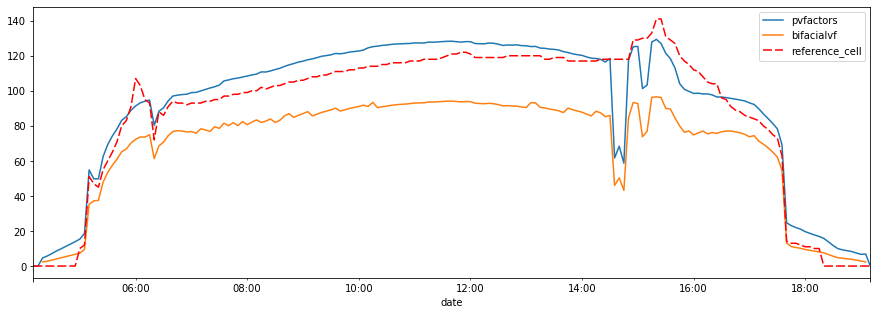

In [22]:
pvfactors_out[day].qinc_back_3.plot(figsize=(15,5))
bifacialvf_out[day].qinc_back_3.plot()
data.reference_cells[day].ref_B2.plot(color='red', dashes=(6,2))
plt.legend(['pvfactors', 'bifacialvf', 'reference_cell'])